# Semaine 14 - Reinforcement Learning, Policy Gradient

Dans l'exercice de cette semaine, nous ...

Voici le lien vers la documentation de *Gym*:   https://gym.openai.com/docs/

In [1]:
import numpy as np
import _pickle as pickle
import gym
import matplotlib.pyplot as plt

# L'environnement

Dans Pong, il faut apprendre au joueur de droite à annalyser la trajectoire de la balle et à déplacer la raquette pour renvoyer la balle dans le camps adverse à l'endroit où il ne peut la renvoyer et gagner des points.

In [2]:
env = gym.make('Pong-v0')
env.reset()
for timestep in range(200):
    env.render()
    env.step(2)
env.close()

Le joueur dispose de 6 actions possibles:

In [3]:
env.action_space.n

6

Testez différentes valeurs pour la variable "action" afin de découvrir comment est encodé le choix de l'action pour le passer à l'environnement au travers de la méthode step()

In [4]:
action = 0

env = gym.make('Pong-v0')
env.seed(42)
env.reset()
for timestep in range(200):
    env.render()
    env.step(action)
env.close()

# Les observations et les états

L'environnement fournit à l'agent une image du jeu

In [5]:
env.observation_space

Box(210, 160, 3)

Les observations sont renvoyées par deux différentes méthodes de l'environnement:

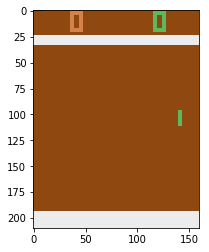

In [6]:
observation = env.reset()
observation, reward, done, info = env.step(action)
plt.imshow(observation) 

# Implémentation du Pong

# hyperparameters

In [80]:
H = 200 # number of hidden layer neurons
batch_size = 10 # every how many episodes to do a param update?
learning_rate = 1e-4
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?
render = True

# model initialization

In [81]:
D = 80 * 80 # input dimensionality: 80x80 grid
if resume:
    model = pickle.load(open('save.p', 'rb'))
else:
    model = {}
    model['W1'] = np.random.randn(H,D) / np.sqrt(D) # "Xavier" initialization
    model['W2'] = np.random.randn(H) / np.sqrt(H)
    
grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } # update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory

Sigmoid

In [82]:
def sigmoid(x): 
  return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector

In [83]:
def prepro(I):
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()

take 1D float array of rewards and compute discounted reward

In [84]:
def discount_rewards(r):
    """
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
            running_add = running_add * gamma + r[t]
            discounted_r[t] = running_add
    """
    return discounted_r

In [85]:
def policy_forward(x):
    
    """
        h = np.dot(model['W1'], x)
        h[h<0] = 0 # ReLU nonlinearity
        logp = np.dot(model['W2'], h)
        p = sigmoid(logp)
    """
    return p, h # return probability of taking action 2, and hidden state

backward pass. (eph is array of intermediate hidden states)

In [86]:
def policy_backward(eph, epdlogp):
    
    """
        dW2 = np.dot(eph.T, epdlogp).ravel()
        dh = np.outer(epdlogp, model['W2'])
        dh[eph <= 0] = 0 # backpro prelu
        dW1 = np.dot(dh.T, epx)
    """
    return {'W1':dW1, 'W2':dW2}

In [87]:
env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None # used in computing the difference frame
xs,hs,dlogps,drs = [],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 0

In [88]:
# preprocess the observation, set input to network to be difference image
def difference_image():
    global prev_x
    cur_x = prepro(observation)
    diff_x = cur_x - prev_x if prev_x is not None else np.zeros(D)
    prev_x = cur_x
    return diff_x

In [89]:
# forward the policy network and sample an action from the returned probability
def get_action(x):
    aprob, h = policy_forward(x)
    """
        action = 2 if np.random.uniform() < aprob else 3 # roll the dice!
    """
    return action, aprob, h

In [90]:
# record various intermediates (needed later for backprop)
def record_history(x, action, aprob, h):
    xs.append(x) # observation
    hs.append(h) # hidden state for fitting
    y = 1 if action == 2 else 0 # a "fake label"
    dlogps.append(y - aprob) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)

In [91]:
# stack together all inputs, hidden states, action gradients, and rewards for this episode
def get_history():
    global xs, hs, dlogps, drs
    """
        epx = np.vstack(xs)
        eph = np.vstack(hs)
        epdlogp = np.vstack(dlogps)
        epr = np.vstack(drs)
        xs,hs,dlogps,drs = [],[],[],[] # reset array memory
    """
    return epx, eph, epdlogp, epr

In [92]:
# compute the discounted reward backwards through time
def standardize_reward(epr):
    discounted_epr = discount_rewards(epr)
    # standardize the rewards to be unit normal (helps control the gradient estimator variance)
    """
        discounted_epr -= np.mean(discounted_epr)
        discounted_epr /= np.std(discounted_epr)
    """
    return discounted_epr

In [93]:
"""Optimizer function, you don't have to understand it, works like Adam"""
def rmsprop_update():
    for k,v in model.items():
        g = grad_buffer[k] # gradient
        rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
        model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
        grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer

In [94]:
# boring book-keeping
def book_keeping(episode_number):
    global running_reward, reward_sum
    running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
    print('resetting env. episode reward total was %f. running mean: %f', reward_sum, running_reward)
    if episode_number % 100 == 0: pickle.dump(model, open('save.p', 'wb'))
    reward_sum = 0

In [95]:
# """ Trains an agent with (stochastic) Policy Gradients on Pong. Uses OpenAI Gym. """
# import numpy as np
# import _pickle as pickle
# import gym

# # hyperparameters
# H = 200 # number of hidden layer neurons
# batch_size = 10 # every how many episodes to do a param update?
# learning_rate = 1e-4
# gamma = 0.99 # discount factor for reward
# decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
# resume = False # resume from previous checkpoint?
# render = True

# model initialization
# D = 80 * 80 # input dimensionality: 80x80 grid
# if resume:
#   model = pickle.load(open('save.p', 'rb'))
# else:
#   model = {}
#   model['W1'] = np.random.randn(H,D) / np.sqrt(D) # "Xavier" initialization
#   model['W2'] = np.random.randn(H) / np.sqrt(H)
  
# grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } # update buffers that add up gradients over a batch
# rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory

# def sigmoid(x): 
#   return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

# def prepro(I):
#   """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
#   I = I[35:195] # crop
#   I = I[::2,::2,0] # downsample by factor of 2
#   I[I == 144] = 0 # erase background (background type 1)
#   I[I == 109] = 0 # erase background (background type 2)
#   I[I != 0] = 1 # everything else (paddles, ball) just set to 1
#   return I.astype(np.float).ravel()

# def discount_rewards(r):
#   """ take 1D float array of rewards and compute discounted reward """
#   discounted_r = np.zeros_like(r)
#   running_add = 0
#   for t in reversed(range(0, r.size)):
#     if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
#     running_add = running_add * gamma + r[t]
#     discounted_r[t] = running_add
#   return discounted_r

# def policy_forward(x):
#   h = np.dot(model['W1'], x)
#   h[h<0] = 0 # ReLU nonlinearity
#   logp = np.dot(model['W2'], h)
#   p = sigmoid(logp)
#   return p, h # return probability of taking action 2, and hidden state

# def policy_backward(eph, epdlogp):
#   """ backward pass. (eph is array of intermediate hidden states) """
#   dW2 = np.dot(eph.T, epdlogp).ravel()
#   dh = np.outer(epdlogp, model['W2'])
#   dh[eph <= 0] = 0 # backpro prelu
#   dW1 = np.dot(dh.T, epx)
#   return {'W1':dW1, 'W2':dW2}

# env = gym.make("Pong-v0")
# observation = env.reset()
# prev_x = None # used in computing the difference frame
# xs,hs,dlogps,drs = [],[],[],[]
# running_reward = None
# reward_sum = 0
# episode_number = 0

while True:
    if render: env.render()

#     # preprocess the observation, set input to network to be difference image
#     cur_x = prepro(observation)
#     x = cur_x - prev_x if prev_x is not None else np.zeros(D)
#     prev_x = cur_x
    x = difference_image()

#     # forward the policy network and sample an action from the returned probability
#     aprob, h = policy_forward(x)
#     action = 2 if np.random.uniform() < aprob else 3 # roll the dice!
    action, aprob, h = get_action(x)

#     # record various intermediates (needed later for backprop)
#     xs.append(x) # observation
#     hs.append(h) # hidden state
#     y = 1 if action == 2 else 0 # a "fake label"
#     dlogps.append(y - aprob) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)

    record_history(x, action, aprob, h)
    
    # step the environment and get new measurements
    observation, reward, done, info = env.step(action)
    reward_sum += reward

    drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

    if done: # an episode finished
        episode_number += 1

#     # stack together all inputs, hidden states, action gradients, and rewards for this episode
#     epx = np.vstack(xs)
#     eph = np.vstack(hs)
#     epdlogp = np.vstack(dlogps)
#     epr = np.vstack(drs)
#     xs,hs,dlogps,drs = [],[],[],[] # reset array memory
    epx, eph, epdlogp, epr = get_history()

#     # compute the discounted reward backwards through time
#     discounted_epr = discount_rewards(epr)
#     # standardize the rewards to be unit normal (helps control the gradient estimator variance)
#     discounted_epr -= np.mean(discounted_epr)
#     discounted_epr /= np.std(discounted_epr)
    discounted_epr = standardize_reward(epr)

    epdlogp *= discounted_epr # modulate the gradient with advantage (PG magic happens right here.)
    grad = policy_backward(eph, epdlogp)
    for k in model: grad_buffer[k] += grad[k] # accumulate grad over batch

    # perform rmsprop parameter update every batch_size episodes
    if episode_number % batch_size == 0:
        rmsprop_update()

    book_keeping(episode_number)

    observation = env.reset() # reset env
    prev_x = None

    if reward != 0: # Pong has either +1 or -1 reward exactly when game ends.
        print('ep %d: game finished, reward: %f', episode_number, reward, '' if reward == -1 else ' !!!!!!!!')

/sgoinfre/goinfre/Perso/hben-yah/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


resetting env. episode reward total was %f. running mean: %f 0.0 0.0
resetting env. episode reward total was %f. running mean: %f 0.0 0.0
resetting env. episode reward total was %f. running mean: %f 0.0 0.0
resetting env. episode reward total was %f. running mean: %f 0.0 0.0
resetting env. episode reward total was %f. running mean: %f 0.0 0.0
resetting env. episode reward total was %f. running mean: %f 0.0 0.0
resetting env. episode reward total was %f. running mean: %f 0.0 0.0
resetting env. episode reward total was %f. running mean: %f 0.0 0.0
resetting env. episode reward total was %f. running mean: %f 0.0 0.0
resetting env. episode reward total was %f. running mean: %f 0.0 0.0
resetting env. episode reward total was %f. running mean: %f 0.0 0.0
resetting env. episode reward total was %f. running mean: %f 0.0 0.0
resetting env. episode reward total was %f. running mean: %f 0.0 0.0
resetting env. episode reward total was %f. running mean: %f 0.0 0.0
resetting env. episode reward tota

KeyboardInterrupt: 